In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from torch.utils.data import DataLoader
from easydict import EasyDict as edict

from src.datasets.load_datasets import MedMNISTDataset
from src.datasets.augmentations import AUGMENTATIONS

from src.utils.logger import setup_logger
from src.utils.generic_utils import seed_everything

from src.trainers.classification import ClassifierTrainer

In [2]:
logger = setup_logger(name='main')
seed_everything()

In [3]:
# preprocessing
download = False
BATCH_SIZE = 64
img_size = 224

data_dir = r"D:\PycharmProjects\Counterfactual-Robustness-Benchmark\data"
data_flag = "pneumoniamnist"
ds_names = ['train', 'val', 'test']

datasets = {}
for ds_name in ds_names:
    transforms = AUGMENTATIONS['standard']
    undersample_flag = False

    if ds_name == 'train':
        transforms = AUGMENTATIONS['advanced']
        undersample_flag = True

    datasets[ds_name] = MedMNISTDataset(data_flag, split=ds_name, 
                                data_dir=data_dir, 
                                size=img_size, 
                                transform=transforms, 
                                download=download,
                                increase_channels=True,
                                undersample=undersample_flag)


logger.info("Pnemounia dataset has been successfully loaded")

values, counts = np.unique_counts(datasets['train'].data.labels)
label_names = datasets['train'].data.info['label']
logger.info(f"Class distribution for the training set: {label_names['0']} : {counts[0]} | {label_names['1']} : {counts[1]}")

[2025-02-11 15:02:17|INFO] - Pnemounia dataset has been successfully loaded
[2025-02-11 15:02:17|INFO] - Class distribution for the training set: normal : 1214 | pneumonia : 1734


In [4]:
train_loader = DataLoader(dataset=datasets['train'], batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=datasets['val'], batch_size=BATCH_SIZE, shuffle=True)

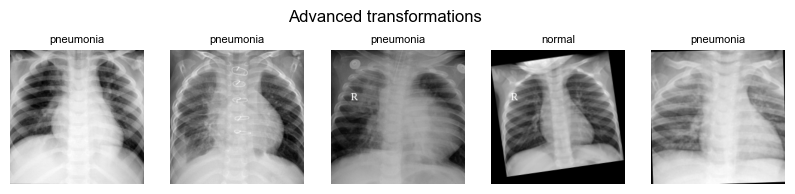

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
params = {"text.color" : "black"}
plt.rcParams.update(params)

n_samples = 5
fig, axs = plt.subplots(1, n_samples, figsize=(10, 6))

batch = next(iter(train_loader))
images = batch[0][:n_samples]
labels = batch[1][:n_samples]

for i in range(n_samples):
    axs[i].imshow(images[i, 0, ...], cmap='gray')
    axs[i].set_title(label_names[str(labels[i].item())], fontdict={'fontsize': 8})
    axs[i].axis("off")

transforms_type = 'Advanced transformations' if len(datasets['train'].transform) > 2  else 'Standard transformations' 
fig.suptitle(transforms_type, y=0.65, verticalalignment="bottom");

# Train classifier

In [9]:
NUM_CLASSES = 2
task = 'multiclass' if NUM_CLASSES > 2  else 'binary'

## Simple CNN from sratch

In [ ]:
from src.models.classifier import CNNtorchUpdated

classifier = CNNtorchUpdated(input_channels=1, img_size=img_size, num_classes=NUM_CLASSES)

In [ ]:
opt_dict = edict({'n_epochs': 15,
                  'optimizer': torch.optim.Adam(classifier.parameters(), lr=1e-3),
                  'criterion': torch.nn.CrossEntropyLoss(),
                  'checkpoint_freq': 20,
                  'dataset_name': data_flag,
                  'task': task,
                  'n_classes': NUM_CLASSES})

In [50]:
experiment_path = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\experiments\train_classifier'
trainer = ClassifierTrainer(opt_dict, classifier, experiment_path=experiment_path) 

[2025-02-07 20:23:46|INFO] - Using model: CNNtorch


In [ ]:
train_stats_history, val_stats_history = trainer.run(train_loader, val_loader)

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')


fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(train_stats_history['loss'], label='train', color='tab:blue')
axs[0].plot(val_stats_history['loss'], label='val', color='tab:orange')
axs[0].legend()
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')

axs[1].plot(train_stats_history['f1score'], label='train', color='tab:blue')
axs[1].plot(val_stats_history['f1score'], label='val', color='tab:orange')
axs[1].legend()
axs[1].set_ylabel('F1 score')
axs[1].set_xlabel('Epochs')

## Transfer Learning

In [7]:
from torchvision.models import resnet18
 

model = resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

In [10]:
fc_in_features = model.fc.in_features 
last_linear = nn.Linear(fc_in_features, NUM_CLASSES)
model.fc = last_linear

In [11]:
opt_dict = edict({'n_epochs': 25,
                  'optimizer': torch.optim.Adam(model.parameters(), lr=0.001),
                  'criterion': torch.nn.CrossEntropyLoss(),
                  'checkpoint_freq': 0,
                  'n_classes': NUM_CLASSES,
                  'dataset_name': data_flag,
                  'task': task,
                  'visualize_results': True})

In [12]:
experiment_path = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\experiments\train_classifier_resnet18'
trainer = ClassifierTrainer(opt_dict, model, experiment_path=experiment_path) 

[2025-02-11 17:02:41|INFO] - Using model: ResNet


In [ ]:
training_stat, val_stat = trainer.run(train_loader, val_loader)

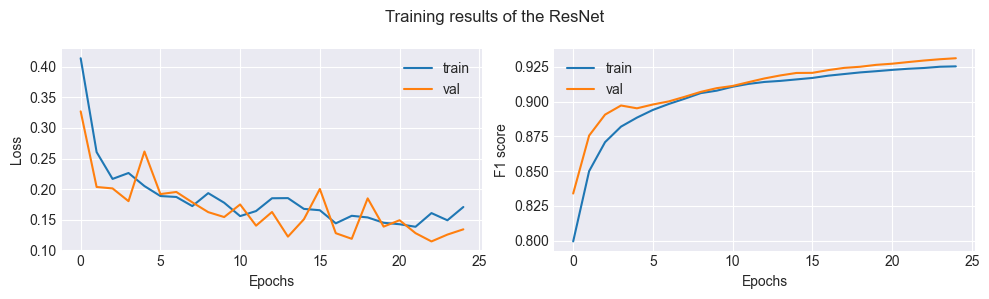

In [34]:
plt.style.use('seaborn-v0_8-darkgrid')


fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(training_stat['loss'], label='train', color='tab:blue')
axs[0].plot(val_stat['loss'], label='val', color='tab:orange')
axs[0].legend()
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')

axs[1].plot(training_stat['f1score'], label='train', color='tab:blue')
axs[1].plot(val_stat['f1score'], label='val', color='tab:orange')
axs[1].legend()
axs[1].set_ylabel('F1 score')
axs[1].set_xlabel('Epochs')
fig.suptitle(f'Training results of the {model.__class__.__name__}')
plt.tight_layout()
fig.savefig(trainer.vis_dir+'/training_results.png')